In [1]:
import numpy as np
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import time
import os.path
import scipy
import pickle as pickle
from struct import unpack
from brian2 import *
import brian2
from brian2tools import *
from PIL import Image
import scipy.signal as signal
import warnings
warnings.simplefilter('ignore')

In [2]:
def plot_spike_counts(name, layer_shape):
    x_L = layer_shape[0]
    y_L = layer_shape[1]
    spike_copy = np.copy(spike_monitors[name].count)
    spike_matrix = np.zeros(layer_shape)
    for i in range(y_L):
        for j in range(x_L):
            spike_matrix[i,j] = spike_copy[i*x_L + j]

    unique_list = unique(spike_matrix)
    max_val = max(unique_list)
    min_val = min(unique_list)

    fig = figure(fig_num, figsize = (6, 6))
    im2 = imshow(spike_matrix, interpolation = "nearest", vmin = min_val, vmax = max_val , cmap = cmap.get_cmap('hot_r'))
    colorbar(im2)
    title('number of spikes - ' + name + ' layer')

In [3]:
def get_spike_counts(name, layer_shape):
    x_L = layer_shape[0]
    y_L = layer_shape[1]
    spike_copy = np.copy(spike_monitors[name].count)
    spike_matrix = np.zeros(layer_shape)
    for i in range(y_L):
        for j in range(x_L):
            spike_matrix[i,j] = spike_copy[i*x_L + j]

    return spike_matrix

In [4]:
def get_matrix_from_file(fileName, shape):
    readout = np.load(fileName)
#     print(readout.shape, fileName)
    value_arr = np.zeros(shape)
    if not readout.shape == (0,):
        value_arr[np.int32(readout[:,0]), np.int32(readout[:,1])] = readout[:,2]
    return value_arr

In [5]:
def gaussian2D(x, y, sigma):
    return (1.0/(1*math.pi*(sigma**2)))*math.exp(-(1.0/(sigma**2))*(x**2 + y**2))

def mexicanHat(x,y,sigma1,sigma2): 
    return gaussian2D(x,y,sigma1) - gaussian2D(x,y,sigma2)

def receptiveFieldMatrix(func):
    h = 5
    g = np.zeros((h,h))
    for xi in range(0,h):
        for yi in range(0,h):
            x = xi-int(h/2)
            y = yi-int(h/2)
            g[xi, yi] = func(x,y);
    return g

In [6]:
def plot_image(image, fig_num):
    unique_list = unique(image)
    max_val = max(unique_list)
    min_val = min(unique_list)
    fig = figure(fig_num, figsize = (5, 5))
#     img = imshow(image, interpolation = "nearest", vmin = min_val, vmax = max_val , cmap = cmap.get_cmap('hot_r'))
    img = imshow(image, interpolation = "nearest", cmap = cmap.get_cmap('binary'))
    colorbar(img)

In [7]:
def tune_stimuli(data):
    data = (data - data.min()) / (data.max() - data.min())
    q95 = np.percentile(data, 95)
    data = np.where((data > q95), q95, data)
    data = np.exp(data*15)
    data = (data - data.min()) / (data.max() - data.min())
    data *= 20
    return data

# CODE

In [8]:
stimuli_file = './pic_120_G.tif'
weight_path = './initial_weights/'
save_path = './saved_weights/'

fig_num = 1

field_size = 2                     # 2/3/4/5/6
w_s = field_size*1                # simple cell width
l_s = field_size*2                # simple_cell_length

c_length = 30
r_length = (c_length*l_s)   # (c_length*2*w_s)
orientations = 4

n_LGN = r_length*r_length
n_L4  = c_length*c_length
n_L3  = n_L4
n_L2  = n_L3

num_epochs = 7

single_example_time = 0.35 * second
resting_time = 0.15 * second

delay = {}
delay = (0*ms, 10*ms)              # min and max delay
minDelay = delay[0]
maxDelay = delay[1]
deltaDelay = maxDelay - minDelay

# neural model parameters
v_rest_e = -65. * mV
v_rest_i = -60. * mV
v_reset_e = -65. * mV
v_reset_i = -45. * mV
v_thresh_e = -52. * mV
v_thresh_i = -40. * mV
refrac_e = 5. * ms
refrac_i = 2. * ms
tc_theta = 1e7 * ms
theta_plus_e = 0.05 * mV
offset = 20.0 * mV

# STDP parameters
tc_pre = 20*ms
tc_post_1 = 20*ms
tc_post_2 = 40*ms
nu_pre =  0.0001
nu_post = 0.01
wmax = 100.0

input_intensity = 1.
start_input_intensity = input_intensity

update_interval = 2

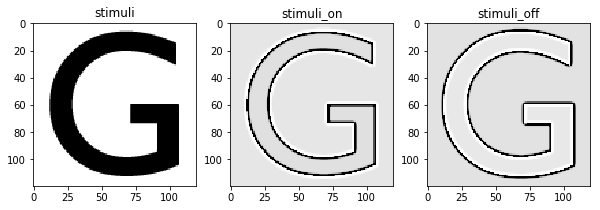

In [9]:
img = Image.open(stimuli_file)
img.load()
img_arr = np.asarray(img, dtype="int32")
stimuli = np.absolute(img_arr)/255
img.close()

stimuli_on = signal.convolve(stimuli, receptiveFieldMatrix(lambda x,y:mexicanHat(x,y,1,1.1)), mode='same')
stimuli_on = tune_stimuli(stimuli_on)

stimuli_off = signal.convolve(stimuli, receptiveFieldMatrix(lambda x,y:mexicanHat(x,y,1.1,1)), mode='same')
stimuli_off = tune_stimuli(stimuli_off)

c, axarr = subplots(1, 3, figsize = (10, 3))

axarr[0].imshow(stimuli, cmap = cmap.get_cmap('binary'))
axarr[0].title.set_text('stimuli')

axarr[1].imshow(stimuli_on, cmap = cmap.get_cmap('binary'))
axarr[1].title.set_text('stimuli_on')

axarr[2].imshow(stimuli_off, cmap = cmap.get_cmap('binary'))
axarr[2].title.set_text('stimuli_off')

In [10]:
scr_e = 'v = v_reset_e; theta += theta_plus_e; timer = 0*ms'
v_reset_i_str = 'v = v_reset_i'

v_thresh_e_str = '(v > (theta - offset + v_thresh_e)) and (timer > refrac_e)'
v_thresh_i_str = 'v > v_thresh_i'

neuron_eqs_e = '''
        dv/dt = ((v_rest_e - v) + g_e*(-v) + g_i*(-100.*mV - v) ) / (100*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
        dtheta/dt = -theta/(1e7*ms)                                : volt
        dtimer/dt = 0.1                                            : second
'''

neuron_eqs_i = '''
        dv/dt = ((v_rest_i - v) +  g_e*(-v) + g_i*(-85.*mV - v)) / (10*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
'''

neuron_groups = {}

neuron_groups_list = [
    ['L4_i_NF', 'i'],
    ['L4_NF', 'e'],
    ['L4_i_FN', 'i'],
    ['L4_FN', 'e'],
    ['L4', 'e'],
    ['L3', 'e']
]

for n_g in neuron_groups_list:
    name = n_g[0]
    e_i = n_g[1]
    if (e_i == 'e'):
        neuron_groups[name] = NeuronGroup(n_L4, neuron_eqs_e, threshold=v_thresh_e_str, refractory=refrac_e, reset=scr_e, method='euler')
        neuron_groups[name].v    = v_rest_e - 40.*mV 
        neuron_groups[name].theta = np.ones((n_L4)) * 20.0*mV
    elif (e_i == 'i'):
        neuron_groups[name] = NeuronGroup(n_L4, neuron_eqs_i, threshold=v_thresh_i_str, refractory=refrac_i, reset=v_reset_i_str, method='euler')
        neuron_groups[name].v    = v_rest_i - 40.*mV 


input_groups = {}
input_groups['LGN_on']   = PoissonGroup(n_LGN, 0*Hz)
input_groups['LGN_off']  = PoissonGroup(n_LGN, 0*Hz)

In [11]:
# without STDP
model = 'w : 1'
pre_e = 'g_e_post += w'
pre_i = 'g_i_post += w'
post = ''

# with STDP
stdp_model = '''
    post2_temp                          : 1
    w                                   : 1
    dpre/dt   =   -pre/(tc_pre)         : 1 (event-driven)
    dpost1/dt  = -post1/(tc_post_1)     : 1 (event-driven)
    dpost2/dt  = -post2/(tc_post_2)     : 1 (event-driven)
'''
stdp_pre_e = 'pre = 1.; w = clip(w + nu_pre * post1, 0, wmax); g_e_post += w;'
stdp_pre_i = 'pre = 1.; w = clip(w + nu_pre * post1, 0, wmax); g_i_post += w;'
stdp_post  = 'post2_temp = post2; post1 = 1.; post2 = 1.; w = clip(w + nu_post * pre * post2_temp, 0, wmax)'

In [12]:
connections = {}
#[name, shape, weight_file, source, target, equation_type]

input_neuron_conn = [
    ['LGN_on_L4_NF', (n_LGN, n_L4), 'LGN_L4_NF.npy', 'LGN_on', 'L4_NF', 'e'],
    ['LGN_off_L4_NF', (n_LGN, n_L4), 'LGN_L4_FN.npy', 'LGN_off', 'L4_NF', 'e'],
    ['LGN_off_L4_i_NF', (n_LGN, n_L4), 'LGN_L4_NF.npy', 'LGN_off', 'L4_i_NF', 'e'],
    ['LGN_on_L4_i_NF', (n_LGN, n_L4), 'LGN_L4_FN.npy', 'LGN_on', 'L4_i_NF', 'e'],
    
    ['LGN_off_L4_FN', (n_LGN, n_L4), 'LGN_L4_NF.npy', 'LGN_off', 'L4_FN', 'e'],
    ['LGN_on_L4_FN', (n_LGN, n_L4), 'LGN_L4_FN.npy', 'LGN_on', 'L4_FN', 'e'],
    ['LGN_on_L4_i_FN', (n_LGN, n_L4), 'LGN_L4_NF.npy', 'LGN_on', 'L4_i_FN', 'e'],
    ['LGN_off_L4_i_FN', (n_LGN, n_L4), 'LGN_L4_FN.npy', 'LGN_off', 'L4_i_FN', 'e'],
]

neuron_neuron_conn = [
    ['L4_i_L4_NF', (n_L4, n_L4), 'L4_L4.npy', 'L4_i_NF', 'L4_NF', 'i'],
    ['L4_i_L4_FN', (n_L4, n_L4), 'L4_L4.npy', 'L4_i_FN', 'L4_FN', 'i'],
    ['L4_NF_L4', (n_L4, n_L4), 'L4_L4.npy', 'L4_NF', 'L4', 'e'],
    ['L4_FN_L4', (n_L4, n_L4), 'L4_L4.npy', 'L4_FN', 'L4', 'e'],
    
    ['L4_L3', (n_L4, n_L3), 'L4_L3.npy', 'L4', 'L3', 'e']
]


for conn in input_neuron_conn:
    name = conn[0]
    shape = conn[1]
    weight_file = conn[2]
    source = conn[3]
    target = conn[4]
    
    weightMatrix = get_matrix_from_file(weight_path + weight_file, shape)
    connections[name]= Synapses(input_groups[source], neuron_groups[target], model=model, on_pre=pre_e, on_post=post)
    connections[name].connect(True)
    connections[name].w = weightMatrix[connections[name].i, connections[name].j]
    connections[name].delay = 'minDelay + rand() * deltaDelay'
    
    
for conn in neuron_neuron_conn:
    name = conn[0]
    shape = conn[1]
    weight_file = conn[2]
    source = conn[3]
    target = conn[4]
    equation = conn[5]
    if (equation == 'e'):
        pre = pre_e
    elif (equation == 'i'):
        pre = pre_i
    
    weightMatrix = get_matrix_from_file(weight_path + weight_file, shape)
    connections[name]= Synapses(neuron_groups[source], neuron_groups[target], model=model, on_pre=pre, on_post=post)
    connections[name].connect(True)
    connections[name].w = weightMatrix[connections[name].i, connections[name].j]

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


In [13]:
spike_counter = SpikeMonitor(neuron_groups['L4'])

# used for ploting after training
spike_monitors = {}

spike_monitors['LGN_on']      = SpikeMonitor(input_groups['LGN_on'])
spike_monitors['LGN_off']     = SpikeMonitor(input_groups['LGN_off'])

for name,_ in neuron_groups_list:
    spike_monitors[name]   = SpikeMonitor(neuron_groups[name])

In [14]:
net = Network()
for obj_list in [neuron_groups, input_groups, connections, spike_monitors]:
    for key in obj_list:
#         print(key, obj_list[key])
        net.add(obj_list[key])
# print('spike counter', spike_counter)
net.add(spike_counter)

In [15]:
previous_spike_count = np.zeros(n_L4)

input_groups['LGN_on'].rates = 0 * Hz
input_groups['LGN_off'].rates = 0 * Hz

net.run(0*second)

j = 0

In [16]:
while j < (num_epochs):

    spike_rates_on = stimuli_on.reshape((n_LGN)) / 8. *  input_intensity
    spike_rates_off = stimuli_off.reshape((n_LGN)) / 8. *  input_intensity
    
    input_groups['LGN_on'].rates = spike_rates_on * Hz
    input_groups['LGN_off'].rates = spike_rates_off * Hz
    
    print('run example number:', j, 'of', num_epochs)
    
    net.run(single_example_time, report='text')   # 0.35 s

    current_spike_count = np.asarray(spike_counter.count[:]) - previous_spike_count
    previous_spike_count = np.copy(spike_counter.count[:])
    
    if np.sum(current_spike_count) < 1:
        if (input_intensity == 10):
            break;
            
        print("F - spike count", np.sum(current_spike_count))
        input_intensity += 1
        
        input_groups['LGN_on'].rates = 0 * Hz
        input_groups['LGN_off'].rates = 0 * Hz
        net.run(resting_time) 
    
    else:     
        print("S - spike count", np.sum(current_spike_count))
        
        if j % 100 == 0 and j > 0:
            print('runs done:', j, 'of', num_epochs)

        input_groups['LGN_on'].rates = 0 * Hz
        input_groups['LGN_off'].rates = 0 * Hz
        
        net.run(resting_time)
        input_intensity = start_input_intensity
        j += 1

run example number: 0 of 7
Starting simulation at t=0. s for a duration of 0.35 s
0.2132 (60%) simulated in 10s, estimated 6s remaining.
0.35 (100%) simulated in 16s
S - spike count 26.0
run example number: 1 of 7
Starting simulation at t=0.5 s for a duration of 0.35 s
0.08354705882352943 (23%) simulated in 10s, estimated 32s remaining.
0.35 (100%) simulated in 16s
S - spike count 55
run example number: 2 of 7
Starting simulation at t=1. s for a duration of 0.35 s
0.05151481481481483 (14%) simulated in 10s, estimated 58s remaining.
0.35 (100%) simulated in 17s
S - spike count 58
run example number: 3 of 7
Starting simulation at t=1.5 s for a duration of 0.35 s
0.04061891891891894 (11%) simulated in 10s, estimated 1m 16s remaining.
0.35 (100%) simulated in 16s
S - spike count 44
run example number: 4 of 7
Starting simulation at t=2. s for a duration of 0.35 s
0.03074042553191488 (8%) simulated in 10s, estimated 1m 44s remaining.
0.35 (100%) simulated in 17s
S - spike count 49
run exampl

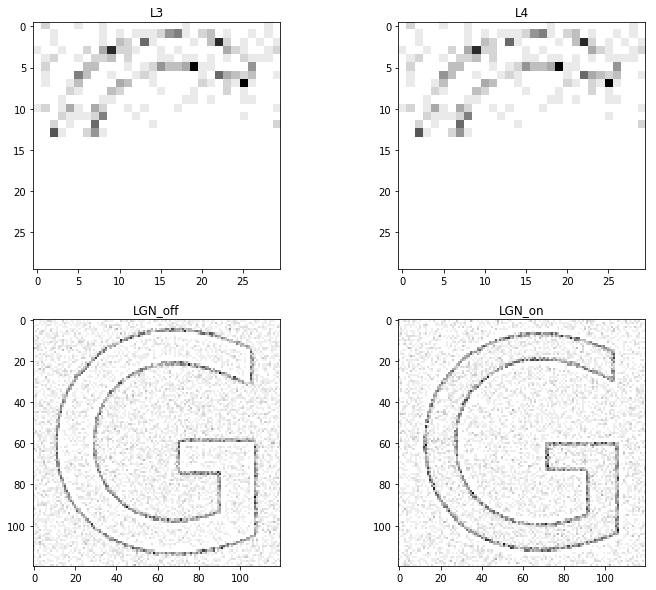

In [17]:
c_shape = (c_length,c_length)
r_shape = (r_length,r_length)
c, axarr = subplots(2, 2, figsize = (12, 10))

axarr[0,0].imshow(get_spike_counts('L3', c_shape), cmap = cmap.get_cmap('binary'))
axarr[0,0].title.set_text('L3')

axarr[0,1].imshow(get_spike_counts('L4', c_shape), cmap = cmap.get_cmap('binary'))
axarr[0,1].title.set_text('L4')

axarr[1,0].imshow(get_spike_counts('LGN_off', r_shape), cmap = cmap.get_cmap('binary'))
axarr[1,0].title.set_text('LGN_off')

axarr[1,1].imshow(get_spike_counts('LGN_on', r_shape), cmap = cmap.get_cmap('binary'))
axarr[1,1].title.set_text('LGN_on')

In [18]:
# plot(state_monitors['L4_v'].t/ms, state_monitors['L4_v'].v[0], label='L4_v')
# plot(state_monitors['L4_i_v'].t/ms, state_monitors['L4_i_v'].v[0], label='L4_i_v')
# xlabel('Time (ms)')
# ylabel('v')
# legend();

In [19]:
plot_spike_counts('L3', shape)
fig_num += 1

IndexError: index 900 is out of bounds for axis 0 with size 900

In [ ]:
plot_spike_counts('L4', shape)
fig_num += 1